# Business Problem

# 0.0. Imports

In [1]:
import random

import numpy   as np
import pandas  as pd
import seaborn as sns

from scipy      import stats           as ss
from keras      import layers          as l
from keras      import models          as ml
from sklearn    import metrics         as m
from sklearn    import preprocessing   as pp
from sklearn    import model_selection as ms
from scikitplot import metrics         as mt

2023-02-14 22:41:42.129753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 22:41:42.275236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 22:41:42.275265: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 22:41:43.251999: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## 0.1. Helper Functions

In [2]:
# cramer v correlation
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-10)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Loading Data

In [3]:
path = '/home/felipe/repos/ds_em_classificacao/'
df_raw = pd.read_csv(path + 'datasets/data_raw/training_users.csv', low_memory=True)
df_sessions = pd.read_csv(path + 'datasets/data_raw/sessions.csv', low_memory=True)

# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Dataset Dimensions

In [5]:
print('Users Dataset')
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Users Dataset
Number of rows: 213451
Number of columns: 16


In [6]:
print('Sessions Dataset')
print('Number of rows: {}'.format(df_sessions.shape[0]))
print('Number of columns: {}'.format(df_sessions.shape[1]))

Sessions Dataset
Number of rows: 10567737
Number of columns: 6


## 1.2. Check NAs

In [7]:
# users dataset NAs
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [8]:
# sessions dataset NAs
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

### 1.2.1. Replace NAs

In [9]:
# # investigate date_first_booking
# aux = df1[df1['date_first_booking'].isna()]
# aux['country_destination'].value_counts(normalize=True)

# # investigate age
# aux = df1[df1['age'].isna()]
# aux['country_destination'].value_counts(normalize=True)
# sns.histplot(data=df1[df1['age']<65], x='age', kde=True);

# # investigate first_affiliate_tracked
# df1['first_affiliate_tracked'].drop_duplicates()

In [10]:
#====================== USERS ================================

# date_first_booking - people with NDF as country_destination
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age - distribution similar to normal distribution
df1 = df1[(df1['age']>15) & (df1['age']<120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked - categorical attribute, hard to replace without bias
df1 = df1[~df1['first_affiliate_tracked'].isna()]

#====================== SESSIONS ================================
# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.3. Check DTypes

In [11]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### 1.3.1. Change DTypes

In [12]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y-%m-%d')

# date_first_booking 
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype('int')

## 1.4. Check Balanced Data

In [13]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.5. Descriptive Analysis

In [14]:
# users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.5.1. Numerical - Users

In [15]:
# central tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.5.2. Numerical - Sessions

In [16]:
# central tendency
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

# dispersion
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

# concat
ct_sessions = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct_sessions.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct_sessions

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.5.3. Categorical - Users

In [17]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.5.4. Categorical - Sessions

In [18]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [19]:
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()
corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list = []
    
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
               
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append a list
        corr_list.append(corr)
    
    # append correlation list for each ref attributes
    corr_dict[ref] = corr_list

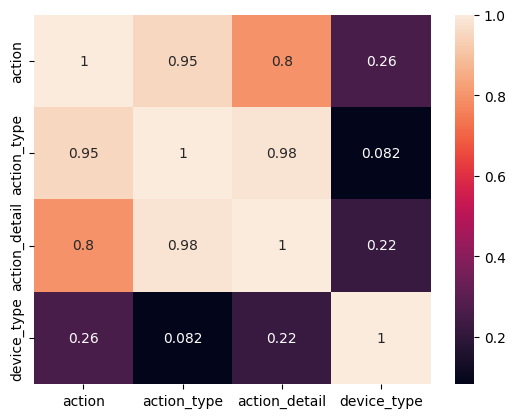

In [20]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 2.0. Feature Engineering

In [21]:
df2 = df1.copy()

## 2.1. Create New Features

In [22]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'], format('%Y-%m-%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking']-df2['first_active']).apply(lambda x: x.days)

# days from first active up to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created']-df2['first_active']).apply(lambda x: x.days)

# days from account created up to first booking
df2['days_from_account_created_until_booking'] = (df2['date_first_booking']-df2['date_account_created']).apply(lambda x: x.days)

#======================FIRST ACTIVE===============================
# year first active
df2['year_first_active'] = df2['first_active'].dt.year
# month first active
df2['month_first_active'] = df2['first_active'].dt.month
# day first active
df2['day_first_active'] = df2['first_active'].dt.day
# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek
# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

#======================FIRST ACTIVE===============================
# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year
# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month
# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day
# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek
# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

#======================FIRST ACCOUNT CREATED===============================
# year first account_created
df2['year_account_created'] = df2['date_account_created'].dt.year
# month first account_created
df2['month_account_created'] = df2['date_account_created'].dt.month
# day first account_created
df2['day_account_created'] = df2['date_account_created'].dt.day
# day of week first account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek
# week of year first account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

/tmp/ipykernel_21504/84586845.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
/tmp/ipykernel_21504/84586845.py:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
/tmp/ipykernel_21504/84586845.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


# 3.0. Data Filtering

In [23]:
df3 = df2.copy()

In [24]:
df3.dtypes

id                                                      object
date_account_created                            datetime64[ns]
timestamp_first_active                          datetime64[ns]
date_first_booking                              datetime64[ns]
gender                                                  object
age                                                      int64
signup_method                                           object
signup_flow                                              int64
language                                                object
affiliate_channel                                       object
affiliate_provider                                      object
first_affiliate_tracked                                 object
signup_app                                              object
first_device_type                                       object
first_browser                                           object
country_destination                                    

## 3.1. Filtering Rows

In [25]:
# age - between 15 and 120 years old
df3 = df3[(df2['age']>15) & (df3['age']<120)]

# secs elapsed - there is no possible 0 secs on website
# df_sessions = df_sessions[df_sessions['secs_elapsed']>0]


# 4.0. Data Preparation

In [26]:
df4 = df3.copy()

In [27]:
# dummy variables
df4_dummy = pd.get_dummies(df4.drop(['id', 'country_destination'], axis=1))

# join id and country destination
df4 = pd.concat([df4[['id', 'country_destination']], df4_dummy], axis=1)

In [28]:
df4.shape

(122636, 144)

# 5.0. Feature Selection

In [29]:
# drop columns
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active']
df5 = df4.drop(cols_drop, axis=1)

In [30]:
# split dataset into features and target
X = df5.drop('country_destination', axis=1)
y = df5['country_destination']

In [31]:
# split dataset into train and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

# 5.0. Machine Learning Model

In [32]:
# drop id
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

## 5.1. Baseline Model

In [33]:
country_dest_list = df4['country_destination'].drop_duplicates().sort_values().tolist()
country_dest_weights = df4['country_destination'].value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# random model
yhat_random = random.choices(population=country_dest_list, 
                             weights=country_dest_weights,
                             k=k_num)

Accurary: 0.3612
Balanced Accurary: 0.0813
Kappa Score: 0.0019
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        92
          CA       0.00      0.00      0.00       208
          DE       0.00      0.00      0.00       160
          ES       0.01      0.01      0.01       286
          FR       0.03      0.02      0.03       767
          GB       0.02      0.02      0.02       334
          IT       0.01      0.01      0.01       440
         NDF       0.45      0.45      0.45     11016
          NL       0.01      0.01      0.01       111
          PT       0.00      0.00      0.00        29
          US       0.39      0.40      0.39      9619
       other       0.05      0.06      0.05      1466

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

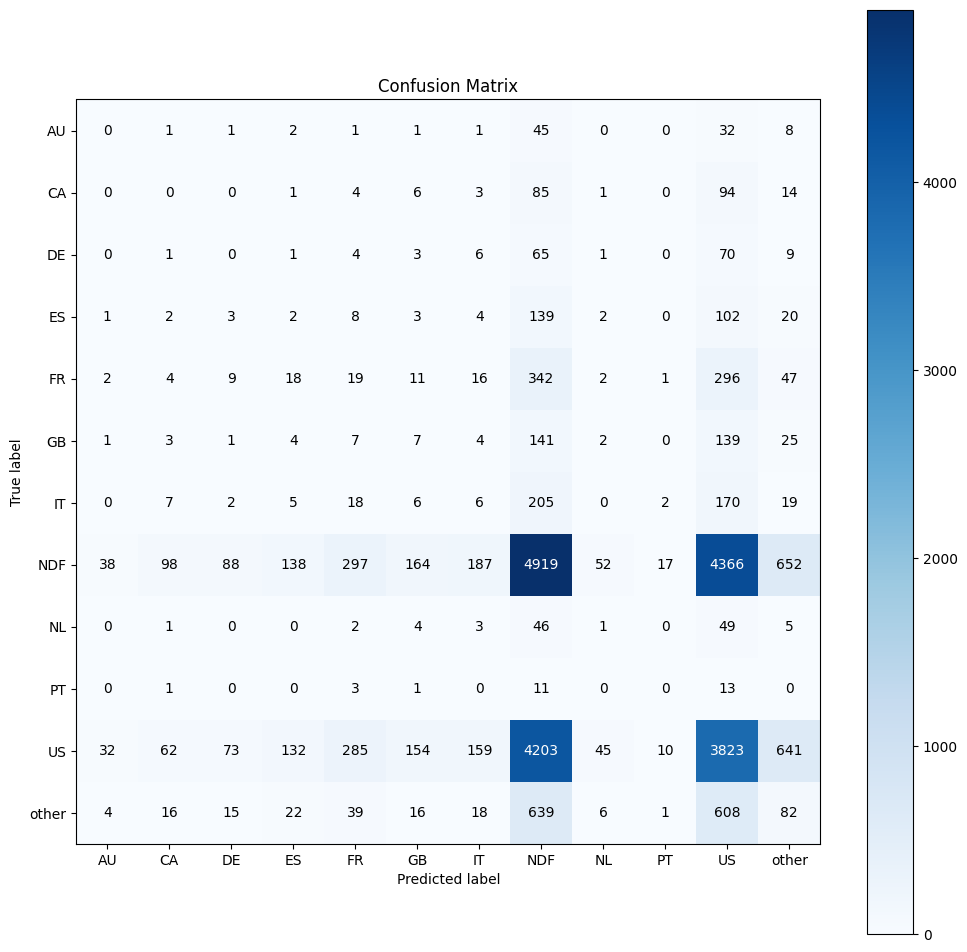

In [34]:
# accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accurary: {:.4f}'.format(acc_random))

# balanced accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accurary: {:.4f}'.format(balanced_acc_random))

# kappa score
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {:.4f}'.format(kappa_random))

# classification report
print(m.classification_report(y_test, yhat_random))

# confusion matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12))

## 5.2. Neural Network - MLP

In [35]:
# transform y_train in dummy to use in the neural network
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [36]:
# model definition
model = ml.Sequential()
model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=100)

2023-02-14 22:42:52.409812: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-14 22:42:52.409850: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-14 22:42:52.409884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: q550lf
2023-02-14 22:42:52.409897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: q550lf
2023-02-14 22:42:52.410058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-02-14 22:42:52.410121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-02-14 22:42:52

Epoch 1/100
3066/3066 [==============================] - 9s 2ms/step - loss: 58.8286 - accuracy: 0.6967
Epoch 2/100
3066/3066 [==============================] - 7s 2ms/step - loss: 24.5452 - accuracy: 0.7218
Epoch 3/100
3066/3066 [==============================] - 6s 2ms/step - loss: 9.0444 - accuracy: 0.7277
Epoch 4/100
3066/3066 [==============================] - 6s 2ms/step - loss: 3.1695 - accuracy: 0.7400
Epoch 5/100
3066/3066 [==============================] - 6s 2ms/step - loss: 1.3217 - accuracy: 0.7706
Epoch 6/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.8243 - accuracy: 0.8059
Epoch 7/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6855 - accuracy: 0.8308
Epoch 8/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6645 - accuracy: 0.8340
Epoch 9/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6619 - accuracy: 0.8349
Epoch 10/100
3066/3066 [==============================] - 6s 2ms/step -

3066/3066 [==============================] - 6s 2ms/step - loss: 0.6371 - accuracy: 0.8381
Epoch 80/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6362 - accuracy: 0.8383
Epoch 81/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6371 - accuracy: 0.8380
Epoch 82/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6377 - accuracy: 0.8380
Epoch 83/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6369 - accuracy: 0.8381
Epoch 84/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6364 - accuracy: 0.8381
Epoch 85/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6367 - accuracy: 0.8382
Epoch 86/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6372 - accuracy: 0.8380
Epoch 87/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6363 - accuracy: 0.8381
Epoch 88/100
3066/3066 [==============================] - 6s 2ms/step - loss:

### 5.2.3. NN Performance

In [37]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

767/767 [==============================] - 1s 1ms/step


Accurary: 0.8413
Balanced Accurary: 0.1667
Kappa Score: 0.7274


/home/felipe/repos/ds_em_classificacao/airbnb_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/felipe/repos/ds_em_classificacao/airbnb_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/felipe/repos/ds_em_classificacao/airbnb_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        92
          CA       0.00      0.00      0.00       208
          DE       0.00      0.00      0.00       160
          ES       0.00      0.00      0.00       286
          FR       0.00      0.00      0.00       767
          GB       0.00      0.00      0.00       334
          IT       0.00      0.00      0.00       440
         NDF       1.00      1.00      1.00     11016
          NL       0.00      0.00      0.00       111
          PT       0.00      0.00      0.00        29
          US       0.71      1.00      0.83      9619
       other       0.00      0.00      0.00      1466

    accuracy                           0.84     24528
   macro avg       0.14      0.17      0.15     24528
weighted avg       0.73      0.84      0.78     24528



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

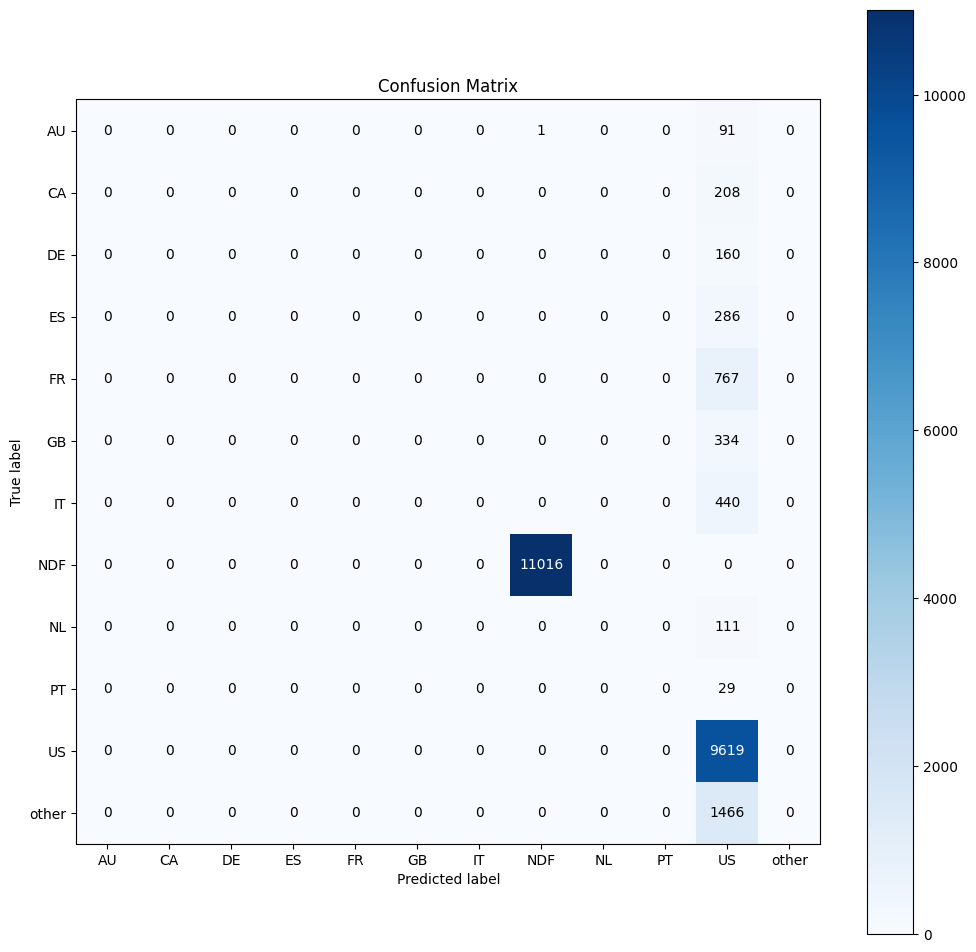

In [38]:
# accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accurary: {:.4f}'.format(acc_nn))

# balanced accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accurary: {:.4f}'.format(balanced_acc_nn))

# kappa score
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {:.4f}'.format(kappa_nn))

# classification report
print(m.classification_report(y_test_nn, yhat_nn))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12, 12))


# 6.0. CROSS VALIDATION

## 6.1. NN Cros Validation

In [39]:
# # generate k-fold
# num_fold = 5
# kfold = ms.StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=32)

# balanced_acc_list = []
# kappa_list = []
# metrics = []

# i = 1

# for train_ix, val_ix in kfold.split(x_train, y_train):
#     # fold number
#     print('Fold Number: {}/{}'.format(i, num_fold))
#     # get fold
#     x_train_fold = x_train.iloc[train_ix]
#     y_train_fold = y_train.iloc[train_ix]
    
#     x_val_fold = x_train.iloc[val_ix]
#     y_val_fold = y_train.iloc[val_ix]

#     # target hot-encoding
#     ohe = pp.OneHotEncoder()
#     y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

#     # model definition
#     model = ml.Sequential()
#     model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
#     model.add(l.Dense(11, activation='softmax'))

#     # compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # training model
#     model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
    
#     # prediction
#     pred_nn = model.predict(x_val_fold)
#     yhat_nn = ohe.inverse_transform(pred_nn)
    
#     # prepare data
#     y_test_nn = y_val_fold.to_numpy()
#     yhat_nn = yhat_nn.reshape(1, -1)[0]
    
#     # metrics
#     ## balanced accuracy
#     balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
#     balanced_acc_list.append(balanced_acc_nn)
    
#     ## Kappa score
#     kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
#     kappa_list.append(kappa_nn)
    
#     metrics.append([i, balanced_acc_nn, kappa_nn])
    
#     i += 1

In [40]:
# results_cv = pd.DataFrame(metrics, columns=['kfold', 'balanced_accuracy', 'kappa_score'])
# results_cv

In [41]:
# print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list), 4), 
#                                                 np.round(np.std(balanced_acc_list), 4)))
# print('Avg Kappa: {} +/- {}'. format(np.round(np.mean(kappa_list), 4), 
#                                      np.round(np.std(kappa_list), 4)))